# shp

> Spatially Homogenious Pixels Identification

In [ ]:
#| default_exp cli/shp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from matplotlib import pyplot as plt
import colorcet
from decorrelation.cli.pc import de_pc_thres_ras,de_ras2pc,de_pc2ras, de_idx2bool

In [ ]:
#| export
from itertools import product
import math

import zarr
import cupy as cp
import numpy as np

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from dask_cuda import LocalCUDACluster

from decorrelation.shp import ks_test
from decorrelation.cli.utils.logging import get_logger, log_args
from decorrelation.cli.utils.dask import get_cuda_cluster_arg
from decorrelation.cli.utils.chunk_size import get_pc_chunk_size_from_n_az_chunk, get_az_chunk_size_from_az_chunk_size
from fastcore.script import call_parse

In [ ]:
#| export
@call_parse
@log_args
def de_shp_test(rslc:str, # input: rslc stack
                pvalue:str, # output: the p value of the test
                az_half_win:int, # azimuth half window size
                r_half_win:int, # range half window size
                method:str=None, # SHP identification method,optional. Default: ks
                n_az_chunk:int=None, # number of azimuth chunk
                az_chunk_size:int=None, # azimuth chunk size, optional. Default: the azimuth chunk size in rslc
                log:str=None, # log file, optional. Default: no log file
               ):
    '''SHP identification through hypothetic test.'''
    rslc_path = rslc
    pvalue_path = pvalue

    logger = get_logger(logfile=log)
    if not method: method = 'ks'
    logger.info(f'hypothetic test method: {method}')
    if method != 'ks':
        logger.warning('Currently only KS test is implented. Switching to it.')
        method = 'ks'

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path,rslc_zarr)

    assert rslc_zarr.ndim == 3, " rslcs dimentation is not 3."

    az_chunk_size = get_az_chunk_size_from_az_chunk_size('rslc','pvalue', rslc_zarr.chunks[0], rslc_zarr.shape[0], logger, az_chunk_size=az_chunk_size, n_az_chunk=n_az_chunk)
    chunks=(az_chunk_size,*rslc_zarr.shape[1:])

    logger.info('starting dask CUDA local cluster.')
    with LocalCUDACluster(**get_cuda_cluster_arg()) as cluster, Client(cluster) as client:
        logger.info('dask local CUDA cluster started.')

        cpu_rslc = da.from_zarr(rslc_path,chunks=chunks); logger.darr_info('rslc',cpu_rslc)

        az_win = 2*az_half_win+1
        logger.info(f'azimuth half window size: {az_half_win}; azimuth window size: {az_win}')
        r_win = 2*r_half_win+1
        logger.info(f'range half window size: {r_half_win}; range window size: {r_win}')

        depth = {0:az_half_win, 1:r_half_win, 2:0}; boundary = {0:'none',1:'none',2:'none'}
        cpu_rslc_overlap = da.overlap.overlap(cpu_rslc,depth=depth, boundary=boundary)
        logger.info('setting shared boundaries between rlsc chunks.')
        logger.darr_info('rslc with overlap', cpu_rslc_overlap)

        rslc_overlap = cpu_rslc_overlap.map_blocks(cp.asarray)
        rmli_overlap = da.abs(rslc_overlap)**2
        logger.darr_info('rmli with overlap', rmli_overlap)

        sorted_rmli_overlap = rmli_overlap.map_blocks(cp.sort,axis=-1)

        delayed_ks_test = delayed(ks_test,pure=True,nout=2)
        rmli_delayed = sorted_rmli_overlap.to_delayed()
        p_delayed = np.empty_like(rmli_delayed,dtype=object)
        dist_delayed = np.empty_like(rmli_delayed,dtype=object)

        logger.info('applying test on sorted rmli stack.')
        with np.nditer(p_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as p_it:
            for p_block in p_it:
                idx = p_it.multi_index
                dist_delayed[idx],p_delayed[idx] = delayed_ks_test(rmli_delayed[idx],az_half_win=az_half_win,r_half_win=r_half_win)

                chunk_shape = (*sorted_rmli_overlap.blocks[idx].shape[:-1],az_win,r_win)
                dtype = sorted_rmli_overlap.dtype
                # dist_delayed[idx] = da.from_delayed(dist_delayed[idx],shape=chunk_shape,meta=cp.array((),dtype=dtype))
                p_delayed[idx] = da.from_delayed(p_delayed[idx],shape=chunk_shape,meta=cp.array((),dtype=dtype))

        p = da.block(p_delayed.reshape(*p_delayed.shape,1).tolist())
        # dist = da.block(dist_delayed.reshape(*dist_delayed.shape,1).tolist())
        logger.info('p value generated')
        logger.darr_info('p value', p)

        depth = {0:az_half_win, 1:r_half_win, 2:0, 3:0}; boundary = {0:'none',1:'none',2:'none',3:'none'}
        # dist = da.overlap.trim_overlap(dist,depth=depth,boundary=boundary)
        p = da.overlap.trim_overlap(p,depth=depth,boundary=boundary)
        logger.info('trim shared boundaries between p value chunks')
        logger.darr_info('trimmed p value', p)

        # cpu_dist = da.map_blocks(cp.asnumpy,dist)
        cpu_p = da.map_blocks(cp.asnumpy,p)
        # cpu_p = cpu_p.rechunk((*cpu_p.chunksize[:2],1,1))

        # _cpu_dist = cpu_dist.to_zarr(statistic,overwrite=True,compute=False)
        _cpu_p = cpu_p.to_zarr(pvalue_path,overwrite=True,compute=False)
        logger.info('saving p value.')
        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_cpu_p)
        progress(futures,notebook=False)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

This function is a wrapper of functions in `decorrelation.shp` that provides file interface. Please refer it for the usage. It utilizes dask for parallel and distributed computation. Compared with the functions in `decorrelation.shp`, this function splits the dataset into several chunks and the computation in these chunks can run in parallel on multi-GPUs.

The `r_chunk_size` and `az_chunk_size` is used to determine how many pixels in range and azimuth in one chunk. The chunk size of the output pvalue is also setted according to them.

In [ ]:
# rslc = '../../data/rslc.zarr'
rslc = './raw/rslc.zarr'
pvalue = './shp/pvalue.zarr'

In [ ]:
%%time
de_shp_test(rslc,pvalue,az_half_win=5,r_half_win=5, method=None,az_chunk_size=1000,log='./shp/de_shp_test.log')

2023-10-20 19:31:34 - de_shp_test - INFO - fetching args:
2023-10-20 19:31:34 - de_shp_test - INFO - rslc = './raw/rslc.zarr'
2023-10-20 19:31:34 - de_shp_test - INFO - pvalue = './shp/pvalue.zarr'
2023-10-20 19:31:34 - de_shp_test - INFO - az_half_win = 5
2023-10-20 19:31:34 - de_shp_test - INFO - r_half_win = 5
2023-10-20 19:31:34 - de_shp_test - INFO - method = None
2023-10-20 19:31:34 - de_shp_test - INFO - n_az_chunk = None
2023-10-20 19:31:34 - de_shp_test - INFO - az_chunk_size = 1000
2023-10-20 19:31:34 - de_shp_test - INFO - log = './shp/de_shp_test.log'
2023-10-20 19:31:34 - de_shp_test - INFO - fetching args done.
2023-10-20 19:31:34 - de_shp_test - INFO - hypothetic test method: ks
2023-10-20 19:31:34 - de_shp_test - INFO - ./raw/rslc.zarr zarray shape: (2500, 1834, 17)
2023-10-20 19:31:34 - de_shp_test - INFO - ./raw/rslc.zarr zarray chunks: (1000, 1834, 1)
2023-10-20 19:31:34 - de_shp_test - INFO - ./raw/rslc.zarr zarray dtype: complex64
2023-10-20 19:31:34 - de_shp_test 

This function can also be called from command line directly:

In [ ]:
!de_shp_test -h

usage: de_shp_test [-h] [--method METHOD] [--n_az_chunk N_AZ_CHUNK]
                   [--az_chunk_size AZ_CHUNK_SIZE] [--log LOG]
                   rslc pvalue az_half_win r_half_win

SHP identification through hypothetic test.

positional arguments:
  rslc                           input: rslc stack
  pvalue                         output: the p value of the test
  az_half_win                    azimuth half window size
  r_half_win                     range half window size

options:
  -h, --help                     show this help message and exit
  --method METHOD                SHP identification method,optional. Default: ks
  --n_az_chunk N_AZ_CHUNK        number of azimuth chunk
  --az_chunk_size AZ_CHUNK_SIZE  azimuth chunk size, optional. Default: the
                                 azimuth chunk size in rslc
  --log LOG                      log file, optional. Default: no log file


In [ ]:
#| export
@call_parse
@log_args
def de_select_shp(pvalue:str, # input: pvalue of hypothetic test
                  is_shp:str, # output: bool array indicating the SHPs
                  shp_num:str, # output: integer array indicating number of SHPs
                  p_max:float=0.05, # threshold of p value to select SHP,optional. Default: 0.05
                  n_az_chunk:int=None, # number of point chunks, optional.
                  az_chunk_size:int=None, # point cloud data chunk size, optional
                  log=None, # log file. Default: no log file
                 ):
    '''
    Select SHP based on pvalue of SHP test.
    '''
    is_shp_path = is_shp
    shp_num_path = shp_num
    logger = get_logger(logfile=log)

    p_zarr = zarr.open(pvalue,mode='r'); logger.zarr_info(pvalue, p_zarr)
    assert p_zarr.ndim == 4, " pvalue dimentation is not 4."

    az_chunk_size = get_az_chunk_size_from_az_chunk_size('pvalue','is_shp',p_zarr.chunks[0],p_zarr.shape[0],logger,az_chunk_size=az_chunk_size,n_az_chunk=n_az_chunk)
    chunks=(az_chunk_size,*p_zarr.shape[1:])

    logger.info('starting dask cuda cluster.')
    with LocalCUDACluster(**get_cuda_cluster_arg()) as cluster, Client(cluster) as client:
        logger.info('dask cluster started.')

        p_cpu = da.from_zarr(pvalue,chunks=chunks)
        # p_cpu = da.from_array(p_zarr[:],chunks=chunks)
        logger.darr_info('pvalue', p_cpu)
        p = da.map_blocks(cp.asarray,p_cpu[:])

        is_shp = (p < p_max) & (p >= 0)
        logger.info('selecting SHPs based on pvalue threshold: '+str(p_max))
        logger.darr_info('is_shp', is_shp)

        logger.info('calculate shp_num.')
        shp_num = da.count_nonzero(is_shp,axis=(-2,-1)).astype(cp.int32)
        logger.darr_info('shp_num',shp_num)

        is_shp_cpu = da.map_blocks(cp.asnumpy,is_shp)
        shp_num_cpu = da.map_blocks(cp.asnumpy,shp_num)
        _is_shp = is_shp_cpu.to_zarr(is_shp_path,overwrite=True,compute=False)
        logger.info('saving is_shp.')
        _shp_num = shp_num_cpu.to_zarr(shp_num_path,overwrite=True,compute=False)
        logger.info('saving shp_num.')
        logger.info('computing graph setted. doing all the computing.')

        futures = client.persist([_is_shp,_shp_num])
        progress(futures,notebook=False)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pvalue = './shp/pvalue.zarr'
is_shp = './shp/is_shp.zarr'
shp_num = './shp/num.zarr'
p_max = 0.05
az_chunk_size = 1000

In [ ]:
%%time
de_select_shp(pvalue,is_shp,shp_num,p_max=p_max,az_chunk_size=az_chunk_size)

2023-10-19 22:54:29 - de_select_shp - INFO - fetching args:
2023-10-19 22:54:29 - de_select_shp - INFO - pvalue = './shp/pvalue.zarr'
2023-10-19 22:54:29 - de_select_shp - INFO - is_shp = './shp/is_shp.zarr'
2023-10-19 22:54:29 - de_select_shp - INFO - shp_num = './shp/num.zarr'
2023-10-19 22:54:29 - de_select_shp - INFO - p_max = 0.05
2023-10-19 22:54:29 - de_select_shp - INFO - n_az_chunk = None
2023-10-19 22:54:29 - de_select_shp - INFO - az_chunk_size = 1000
2023-10-19 22:54:29 - de_select_shp - INFO - log = None
2023-10-19 22:54:29 - de_select_shp - INFO - fetching args done.
2023-10-19 22:54:29 - de_select_shp - INFO - ./shp/pvalue.zarr zarray shape: (2500, 1834, 11, 11)
2023-10-19 22:54:29 - de_select_shp - INFO - ./shp/pvalue.zarr zarray chunks: (1000, 1834, 11, 11)
2023-10-19 22:54:29 - de_select_shp - INFO - ./shp/pvalue.zarr zarray dtype: float32
2023-10-19 22:54:29 - de_select_shp - INFO - got az_chunk_size for is_shp: 1000
2023-10-19 22:54:29 - de_select_shp - INFO - start

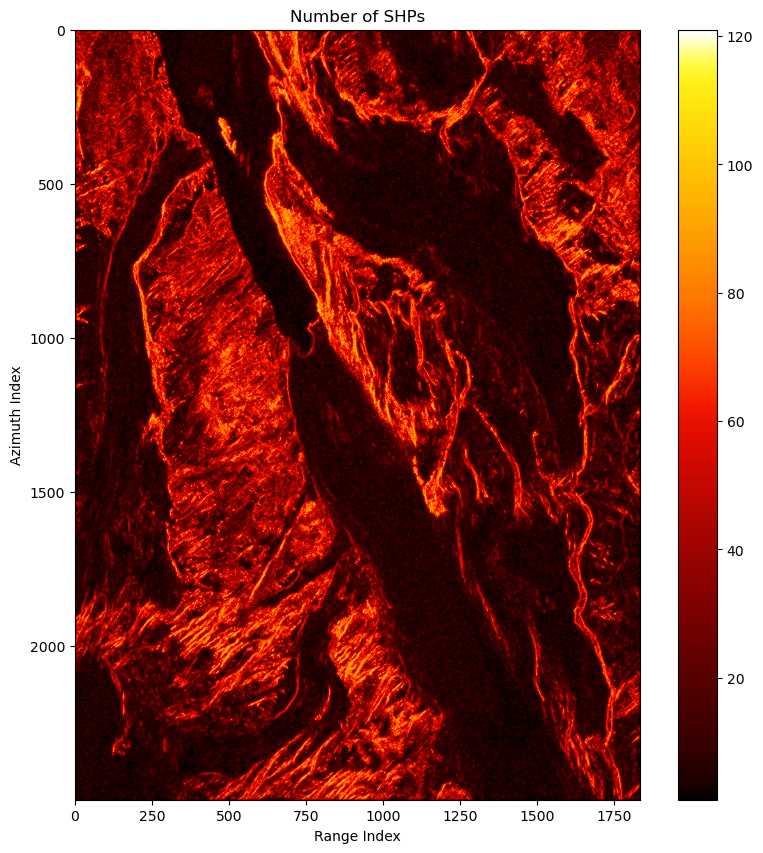

In [ ]:
shp_num_zarr = zarr.open(shp_num,'r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(shp_num_zarr[:],cmap=colorcet.cm.fire)
ax.set(title='Number of SHPs',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

Then we can select DS candidates based on number of SHPs and slice is_shp only on DS candidates.

In [ ]:
ds_can_idx = './shp/ds_can_idx.zarr'
is_ds_can= './shp/is_ds_can.zarr'
ds_can_is_shp = './shp/ds_can_is_shp.zarr'

In [ ]:
de_pc_thres_ras(shp_num,ds_can_idx,min_thres=50)

2023-10-19 22:54:44 - de_pc_thres_ras - INFO - fetching args:
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - ras = './shp/num.zarr'
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - idx = './shp/ds_can_idx.zarr'
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - min_thres = 50
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - max_thres = None
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - pc_chunk_size = None
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - n_pc_chunk = None
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - log = None
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - fetching args done.
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - ./shp/num.zarr zarray shape: (2500, 1834)
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - ./shp/num.zarr zarray chunks: (1000, 1834)
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - ./shp/num.zarr zarray dtype: int32
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - loading ras into memory.
2023-10-19 22:54:44 - de_pc_thres_ras - INFO - select pc based on min_thre

In [ ]:
de_ras2pc(ds_can_idx, is_shp, ds_can_is_shp)
de_idx2bool(ds_can_idx, is_ds_can, shape= shp_num_zarr.shape)

2023-10-19 22:54:44 - de_ras2pc - INFO - fetching args:
2023-10-19 22:54:44 - de_ras2pc - INFO - idx = './shp/ds_can_idx.zarr'
2023-10-19 22:54:44 - de_ras2pc - INFO - ras = './shp/is_shp.zarr'
2023-10-19 22:54:44 - de_ras2pc - INFO - pc = './shp/ds_can_is_shp.zarr'
2023-10-19 22:54:44 - de_ras2pc - INFO - pc_chunk_size = None
2023-10-19 22:54:44 - de_ras2pc - INFO - n_pc_chunk = None
2023-10-19 22:54:44 - de_ras2pc - INFO - hd_chunk_size = None
2023-10-19 22:54:44 - de_ras2pc - INFO - log = None
2023-10-19 22:54:44 - de_ras2pc - INFO - fetching args done.
2023-10-19 22:54:44 - de_ras2pc - INFO - ./shp/ds_can_idx.zarr zarray shape: (2, 740397)
2023-10-19 22:54:44 - de_ras2pc - INFO - ./shp/ds_can_idx.zarr zarray chunks: (2, 246799)
2023-10-19 22:54:44 - de_ras2pc - INFO - ./shp/ds_can_idx.zarr zarray dtype: int32
2023-10-19 22:54:44 - de_ras2pc - INFO - automatically determine pc_chunk_size from pc_chunk_size of idx.
2023-10-19 22:54:44 - de_ras2pc - INFO - pc_chunk_size for pc: 246799

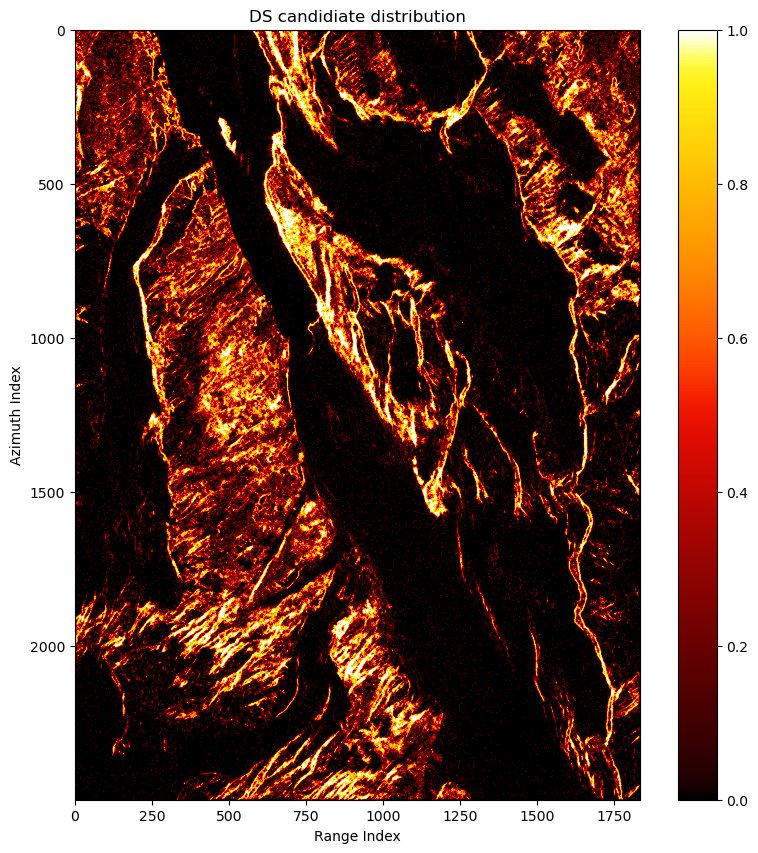

In [ ]:
is_ds_can_zarr = zarr.open(is_ds_can,'r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(is_ds_can_zarr[:],cmap=colorcet.cm.fire)
ax.set(title='DS candidiate distribution',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()